In [2]:
!pip install yfinance
!pip install ta
!pip install stable.baselines3
!pip3 install torch torchvision torchaudio

#!pip install TA-Lib
import warnings
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ta
import os
#import talib
warnings.filterwarnings("ignore")
# Optional Plotly Method Imports
import plotly
import cufflinks as cf
cf.go_offline()


from stable_baselines3 import A2C, PPO, DDPG
from stable_baselines3.common.policies import ActorCriticPolicy #MlpPolicy for A2C and PPO
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import ActionNoise, OrnsteinUhlenbeckActionNoise

sns.set_style('whitegrid')
%matplotlib inline



     |████████████████████████████████| 6.3 MB 17.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=694f9c7417a7133a4087c512ca62329fd7512921fd38928f430f2e91e6c2389f
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28716 sha256=2ea6ec705f7495ea5dfd7784f6c274faf687105666921db1d3bb50911eb790b3
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta
     |████████████████████████████████| 172 kB 13.2 MB/s 
     |████████████████████████████████| 1.9 MB 14.8 MB/s 


**Data Collection**

In [ ]:
#DJIA stocks
tic = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 
       'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 
       'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 
       'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS' ]

In [ ]:
stock_data = pd.DataFrame()
stock_start_date = '2009-01-01'
stock_end_date = '2021-07-01'

for s in tic:

  temp_data = yfinance.download(s, start= stock_start_date, end=stock_end_date)
  temp_data['Ticker'] = s

  stock_data = stock_data.append(temp_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

**Data Exploration**

In [ ]:
stock_data.head()

Open       High        Low  ...  Adj Close   Volume  Ticker
Date                                         ...                            
2009-01-02  57.549999  59.389999  57.520000  ...  41.957760  5313900     MMM
2009-01-05  58.790001  59.090000  58.110001  ...  41.468639  3768800     MMM
2009-01-06  58.740002  59.810001  58.610001  ...  41.957760  4966200     MMM
2009-01-07  58.610001  58.959999  57.580002  ...  41.163818  4598100     MMM
2009-01-08  57.680000  58.709999  57.450001  ...  41.525352  3944900     MMM

[5 rows x 7 columns]

In [ ]:
stock_data.tail()

Open        High         Low  ...   Adj Close    Volume  Ticker
Date                                            ...                              
2021-06-24  176.130005  178.240005  175.779999  ...  177.929993   7549400     DIS
2021-06-25  178.830002  179.089996  177.490005  ...  178.350006   7431800     DIS
2021-06-28  178.500000  178.660004  174.990005  ...  176.570007   9881400     DIS
2021-06-29  176.639999  177.020004  173.800003  ...  173.929993  13498300     DIS
2021-06-30  173.889999  175.979996  173.339996  ...  175.770004   7481900     DIS

[5 rows x 7 columns]

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91781 entries, 2009-01-02 to 2021-06-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       91781 non-null  float64
 1   High       91781 non-null  float64
 2   Low        91781 non-null  float64
 3   Close      91781 non-null  float64
 4   Adj Close  91781 non-null  float64
 5   Volume     91781 non-null  int64  
 6   Ticker     91781 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ MB


In [ ]:
#Unique Trading days
len(stock_data.index.unique())

3145

In [ ]:
stock_data.Ticker.unique()

array(['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
       'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD',
       'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA',
       'WMT', 'DIS'], dtype=object)

In [ ]:
stock_data.shape
#But for 30 stocks with 3145 trading days the shape of the data frame should be (94350,1)

(91781, 7)

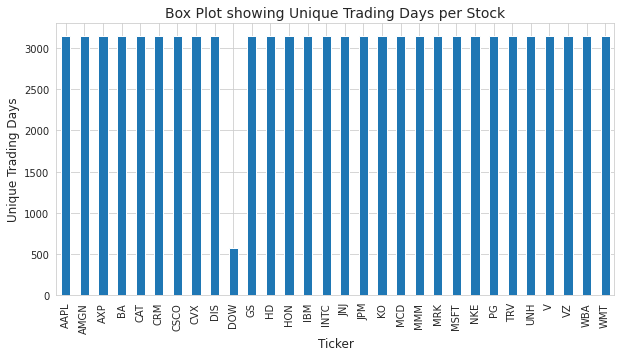

In [ ]:
plt.figure(figsize=(10,5))
stock_data.groupby(by= 'Ticker').count()['Open'].plot(kind = 'bar')
plt.xlabel('Ticker', fontsize = 12)
plt.ylabel('Unique Trading Days', fontsize = 12)
plt.title('Box Plot showing Unique Trading Days per Stock', fontsize = 14)
plt.show()

In [ ]:
stock_data.groupby(by= 'Ticker').count()['Open']

Ticker
AAPL    3145
AMGN    3145
AXP     3145
BA      3145
CAT     3145
CRM     3145
CSCO    3145
CVX     3145
DIS     3145
DOW      576
GS      3145
HD      3145
HON     3145
IBM     3145
INTC    3145
JNJ     3145
JPM     3145
KO      3145
MCD     3145
MMM     3145
MRK     3145
MSFT    3145
NKE     3145
PG      3145
TRV     3145
UNH     3145
V       3145
VZ      3145
WBA     3145
WMT     3145
Name: Open, dtype: int64

In [ ]:
#EDA
df = stock_data.copy()
# Dropping Closing Price Column
df = df.drop('Close', 1)
df = df.drop('Open', 1)
df = df.drop('High', 1)
df = df.drop('Low', 1)
df = df.drop('Volume', 1)
#Remanimg Adj Close
df = df.rename(columns={'Adj Close':'AdjClose'})
df = df.sort_values(by= ['Date', 'Ticker'])
df = df.reset_index()
df = df.pivot(index= 'Date', columns= 'Ticker')
df = df.droplevel(0, axis=1)
df = df.fillna(0)

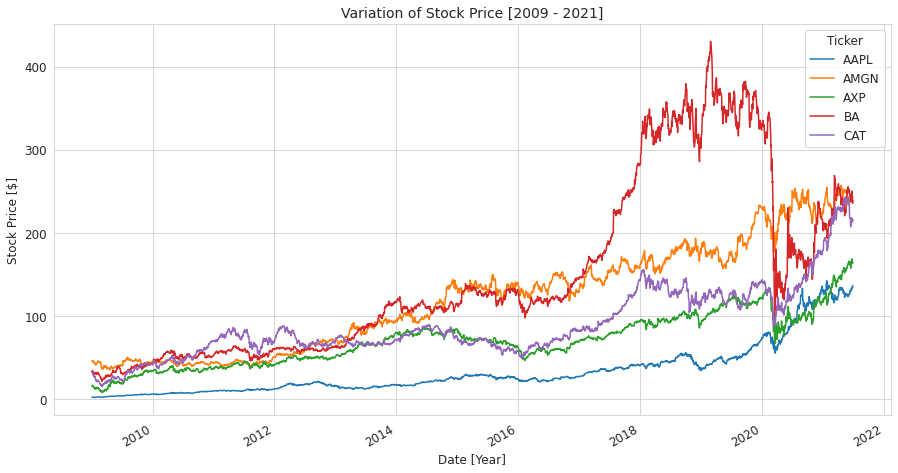

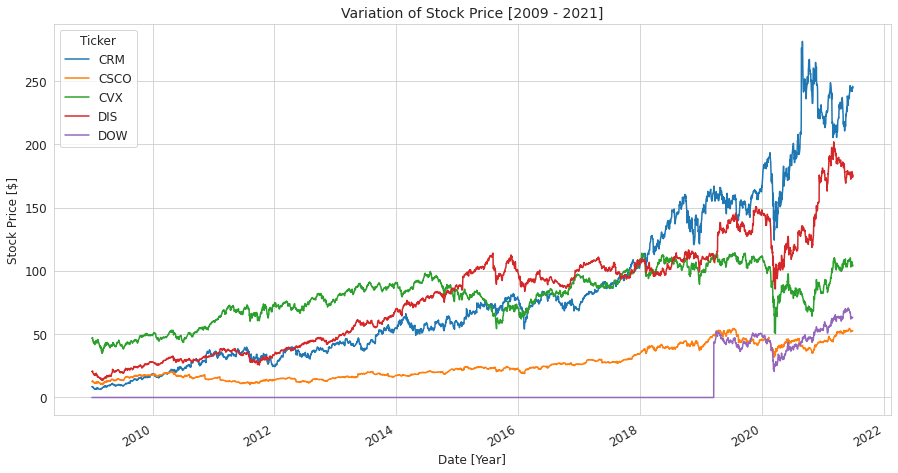

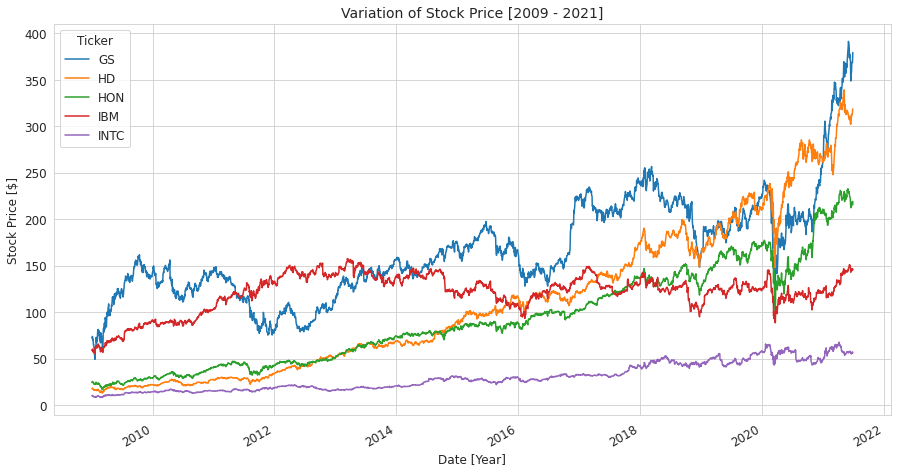

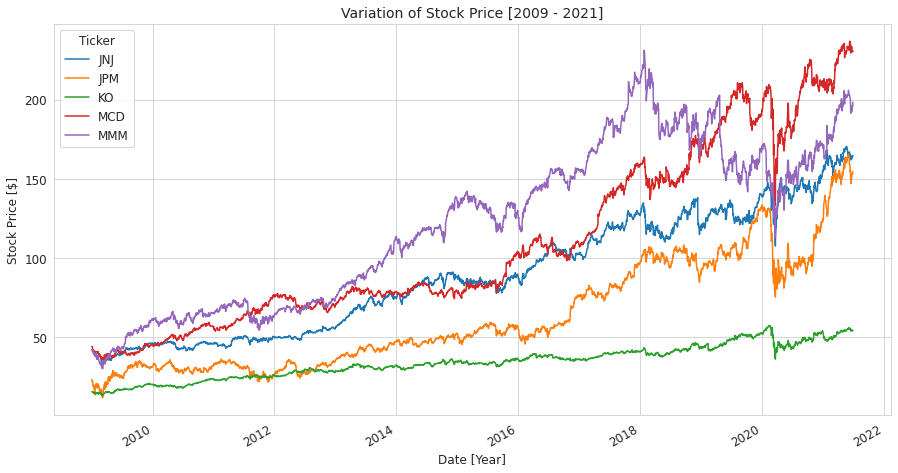

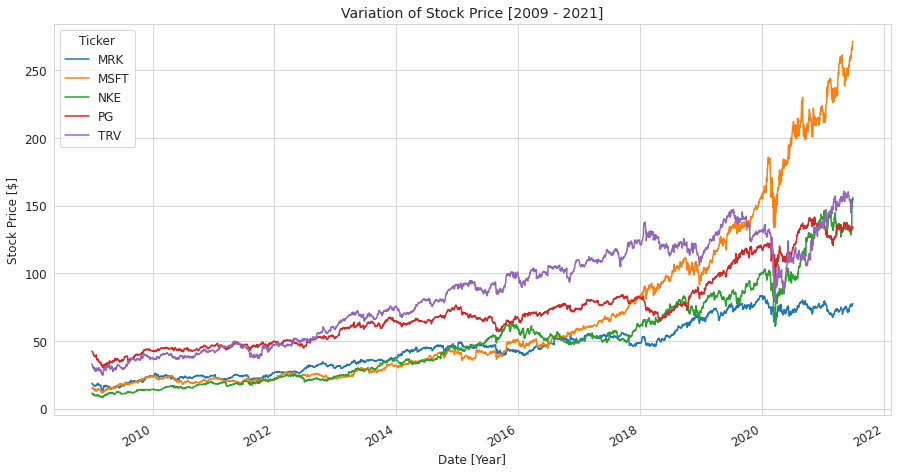

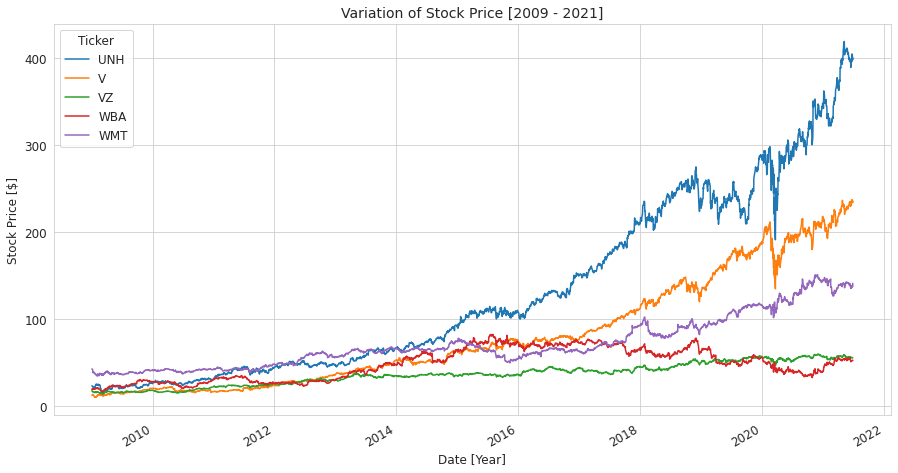

In [ ]:
for i in range(5,35, 5):
  df.iloc[:,(i-5):i].plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
  plt.xlabel('Date [Year]', fontsize = 12)
  plt.ylabel('Stock Price [$]', fontsize = 12)
  plt.legend(loc = 'best', fontsize = 12,title = 'Ticker', title_fontsize = '12')
  plt.title('Variation of Stock Price [2009 - 2021]', fontsize = 14)
  plt.show()

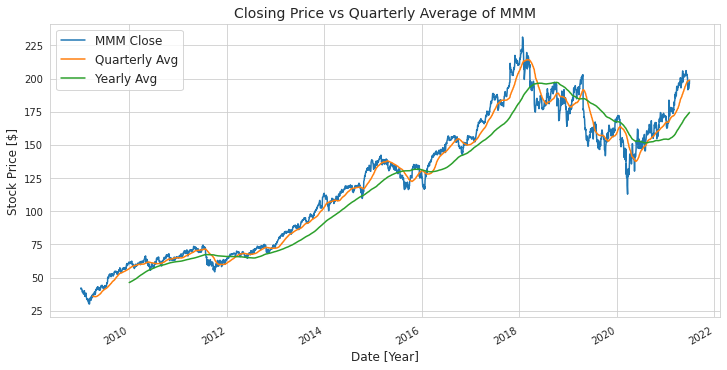

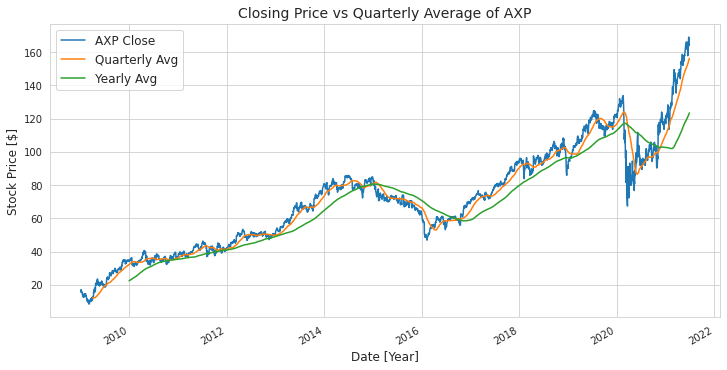

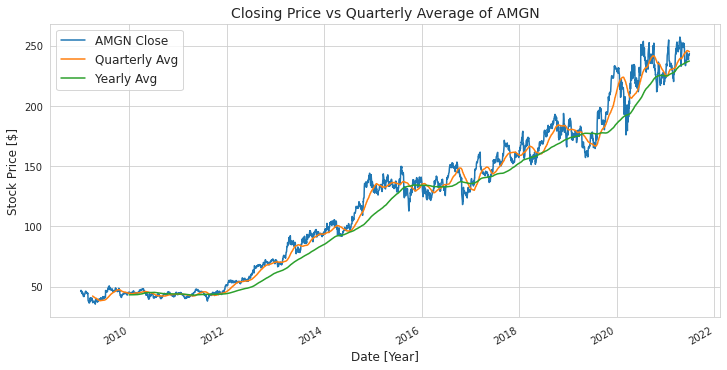

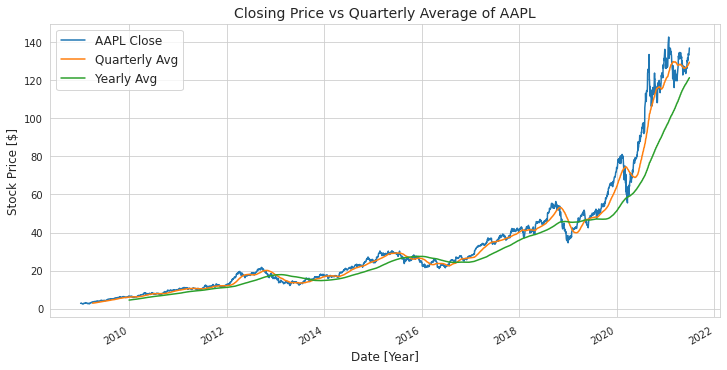

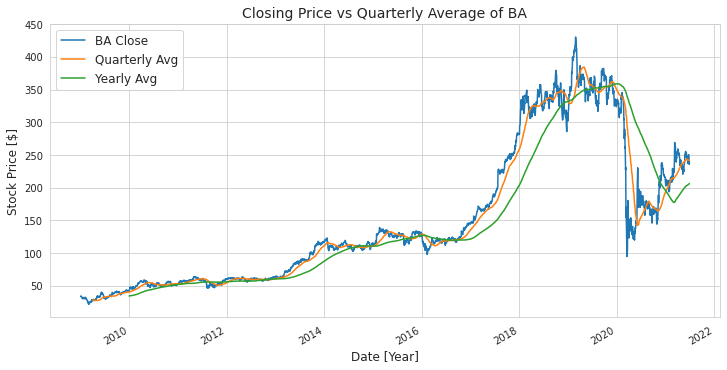

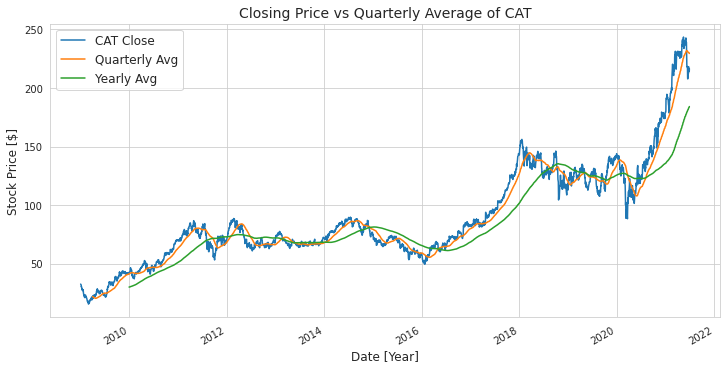

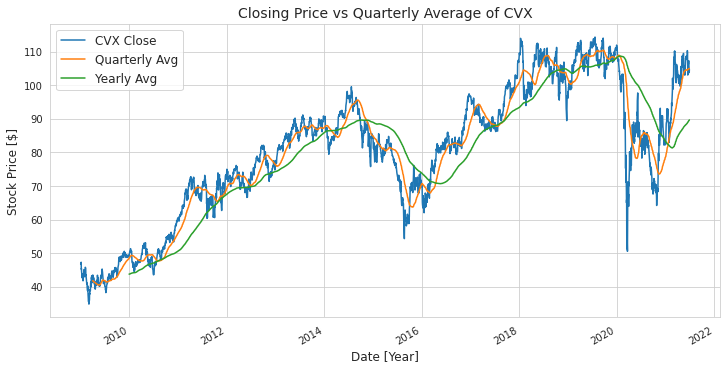

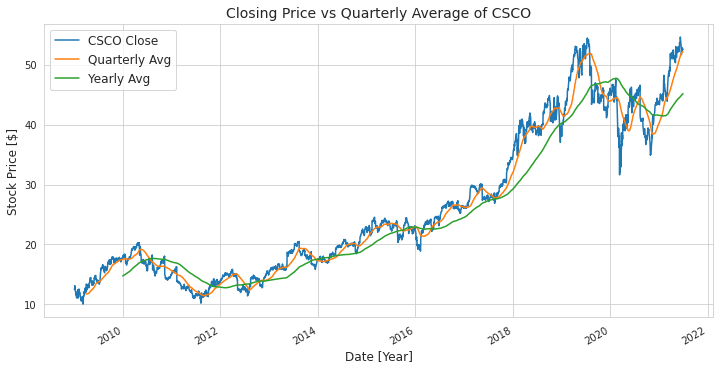

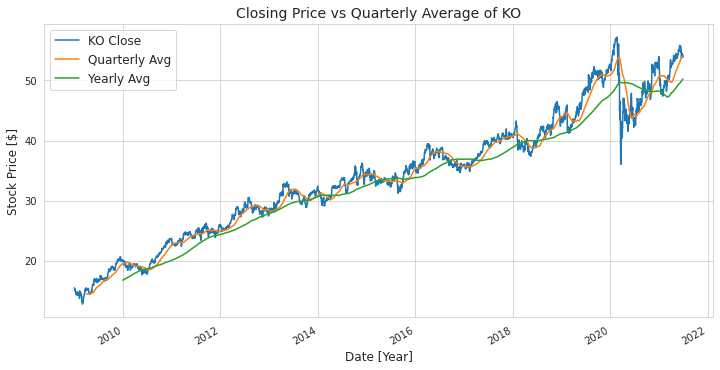

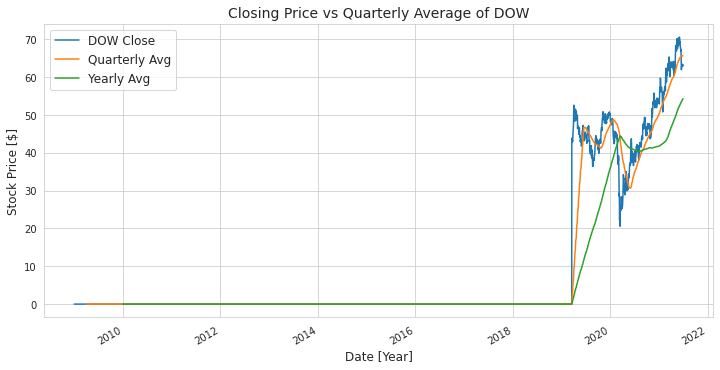

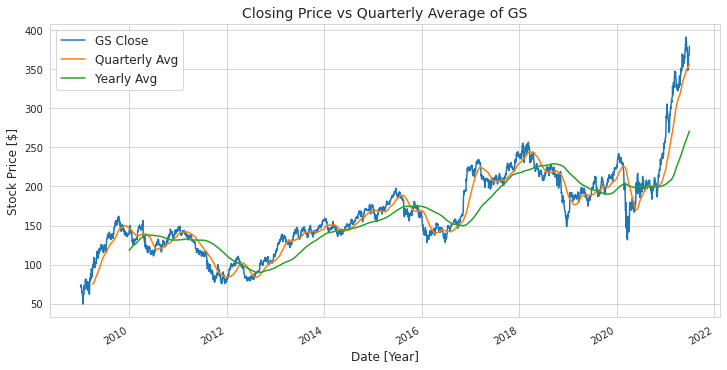

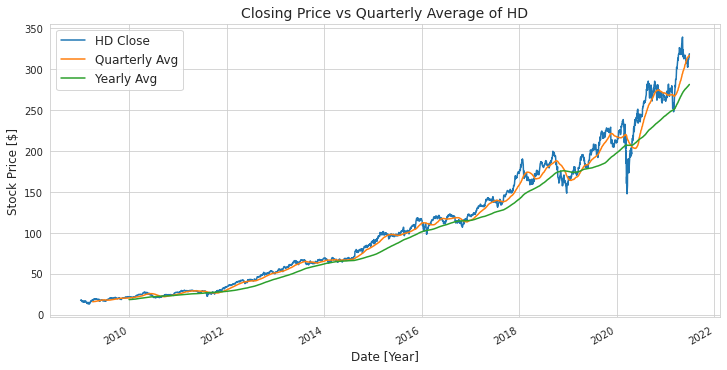

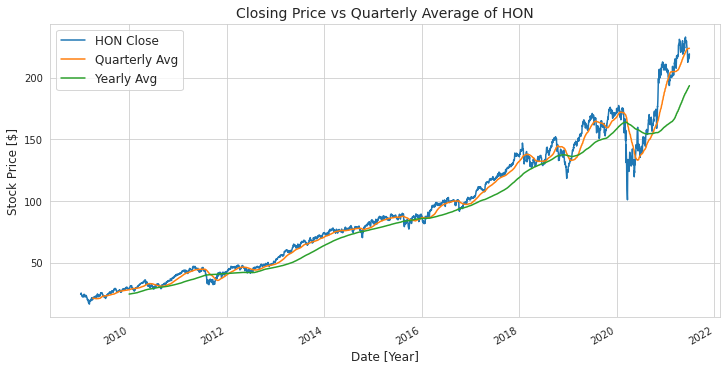

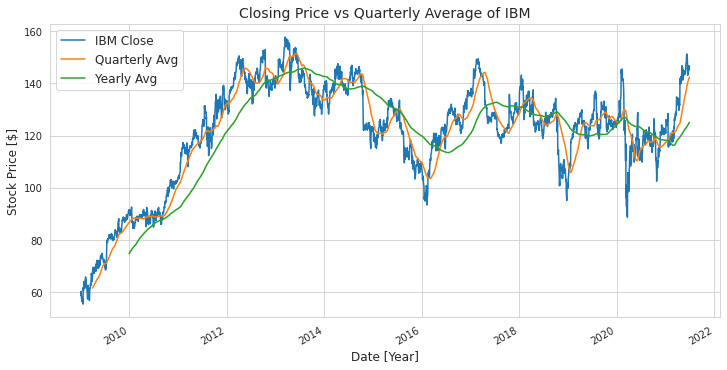

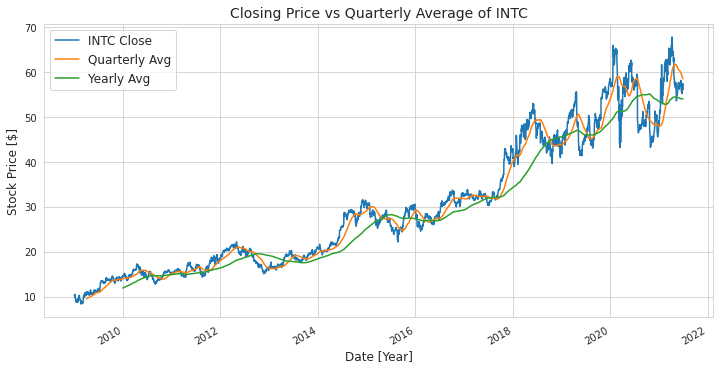

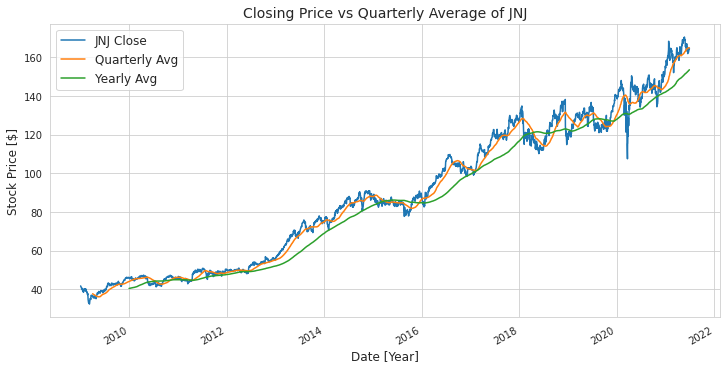

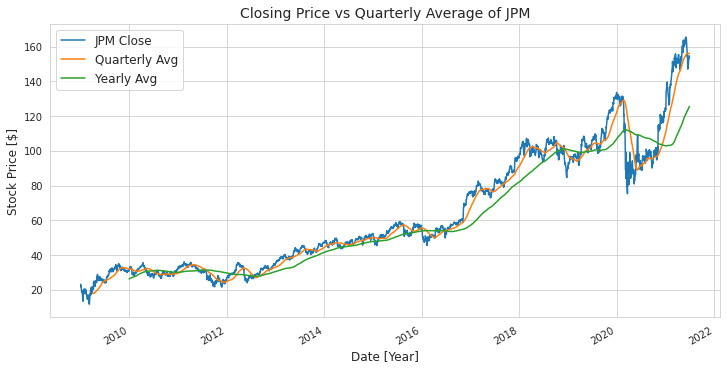

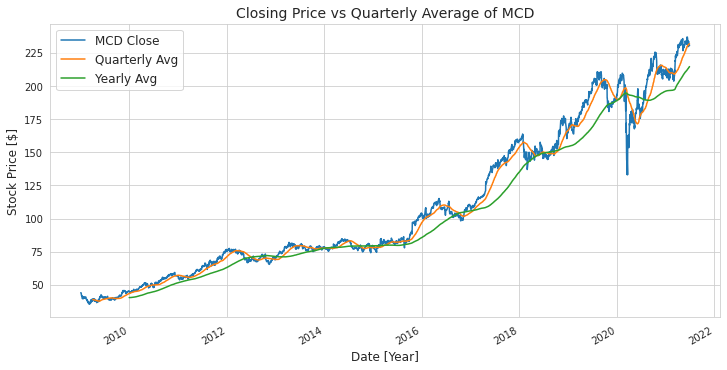

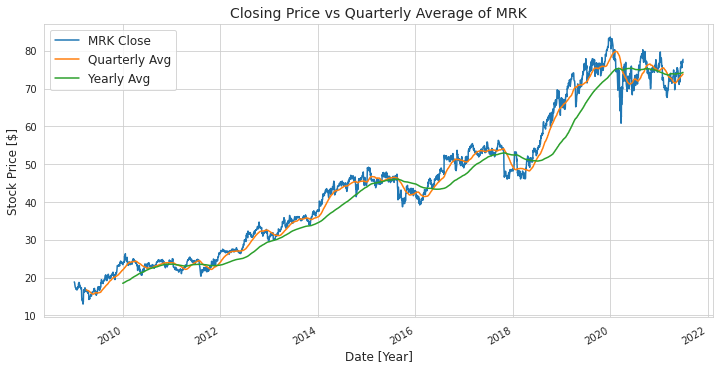

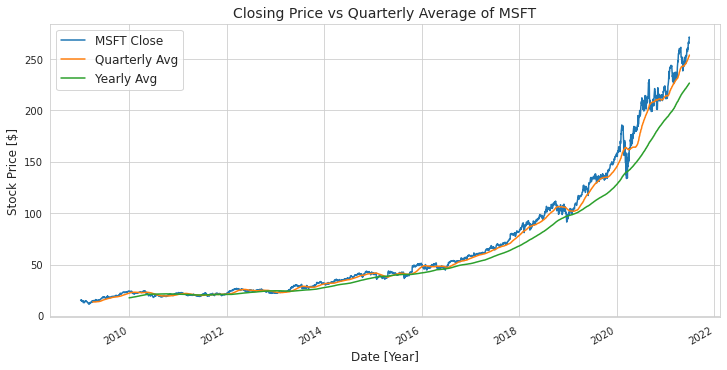

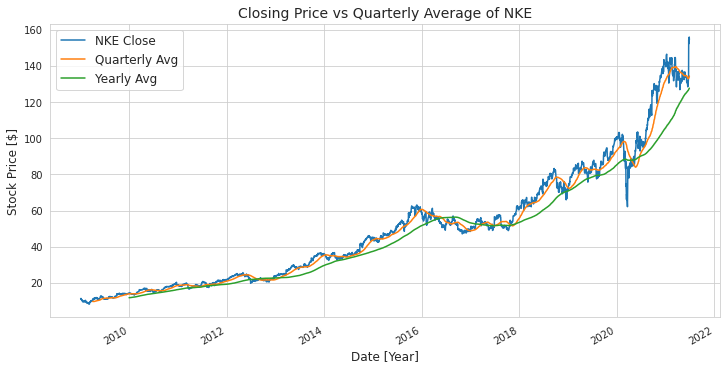

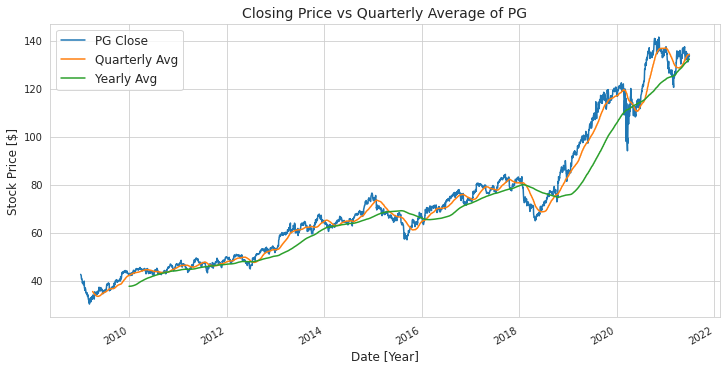

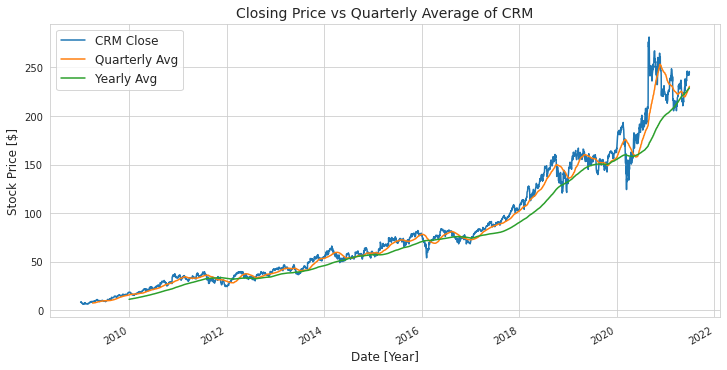

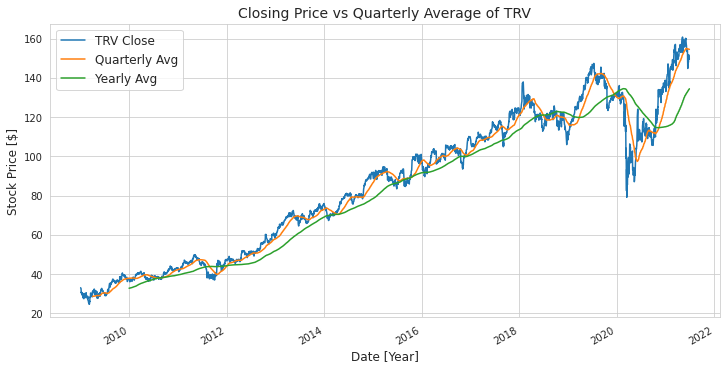

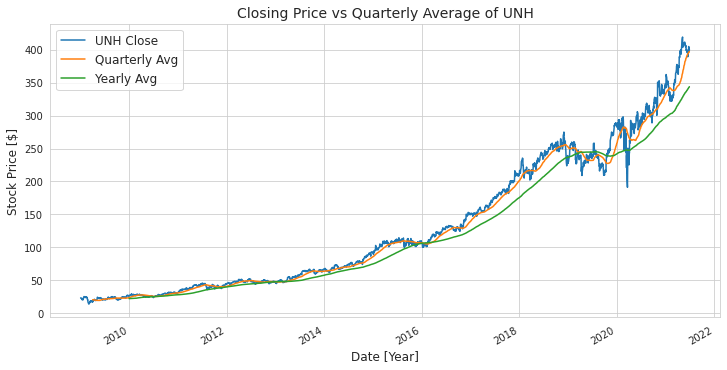

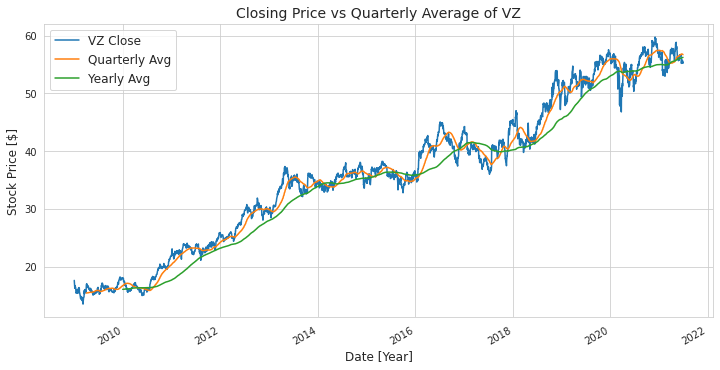

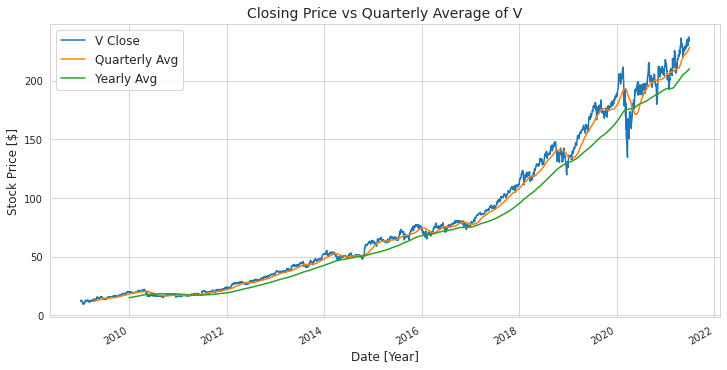

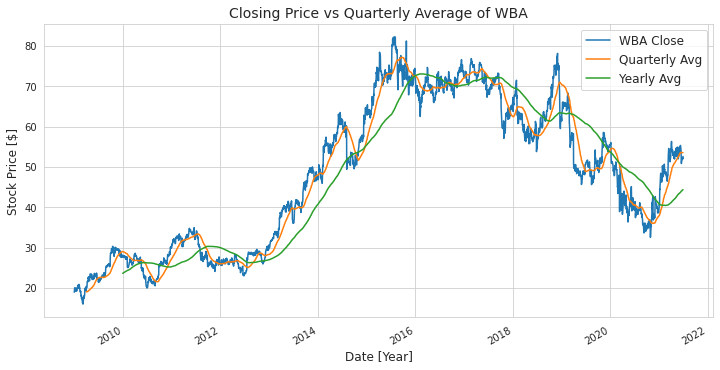

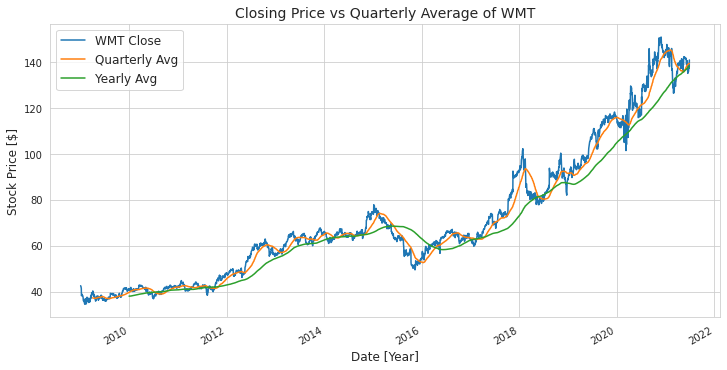

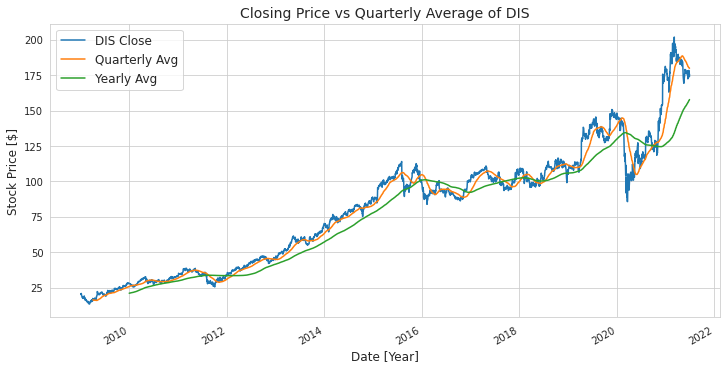

In [ ]:
 for idx in tic:
  plt.figure(figsize=(12,6))
  df[idx].loc['2009-01-01':].plot(label = '{} Close'.format(idx))
  df[idx].loc['2009-01-01':].rolling(window=63).mean().plot(label='Quarterly Avg')
  df[idx].loc['2009-01-01':].rolling(window=252).mean().plot(label='Yearly Avg')
  plt.xlabel('Date [Year]', fontsize = 12)
  plt.ylabel('Stock Price [$]', fontsize = 12)
  plt.legend(loc = 'best', fontsize = 12)
  plt.title('Closing Price vs Quarterly Average of {}'.format(idx), fontsize = 14)
  plt.show()

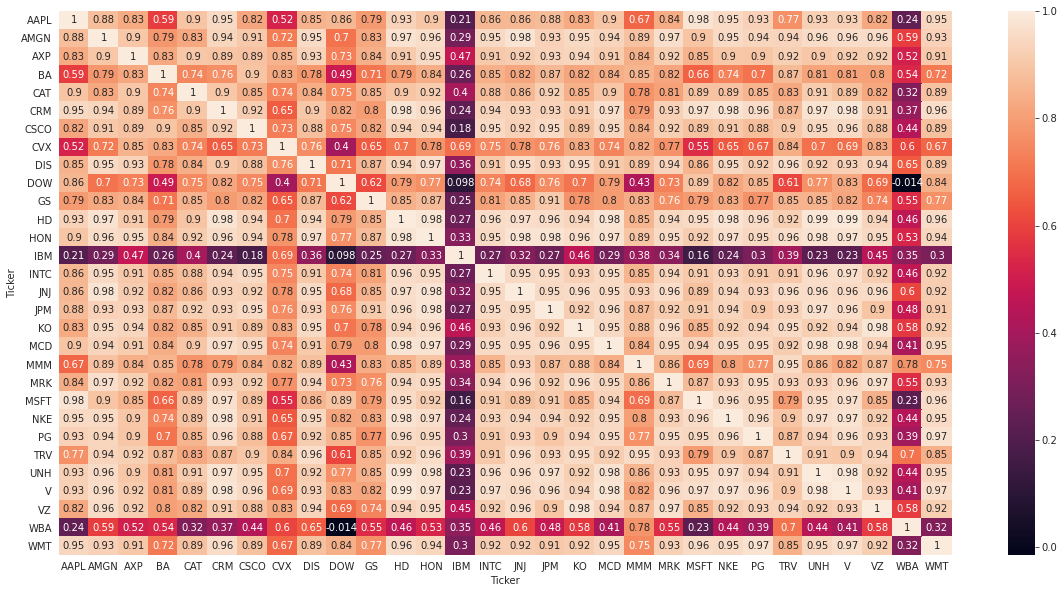

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

In [ ]:
daily_returns = df.pct_change()

daily_returns.describe()

Ticker         AAPL         AMGN  ...          WBA          WMT
count   3144.000000  3144.000000  ...  3144.000000  3144.000000
mean       0.001403     0.000655  ...     0.000485     0.000454
std        0.018101     0.015995  ...     0.017856     0.012129
min       -0.128647    -0.095846  ...    -0.143374    -0.101832
25%       -0.007207    -0.007468  ...    -0.008022    -0.005221
50%        0.001079     0.000468  ...     0.000348     0.000525
75%        0.010831     0.008896  ...     0.009328     0.006193
max        0.119808     0.139192  ...     0.126036     0.117085

[8 rows x 30 columns]

**Data Pre-Processing**

In [ ]:
# Dropping Closing Price Column
stock_data = stock_data.drop('Close', 1)

#Remanimg Adj Close
stock_data = stock_data.rename(columns={'Adj Close':'AdjClose'})

#Resetting the index
stock_data = stock_data.reset_index()

#Sorting the data by Date and Ticker and resetting the index
stock_data = stock_data.sort_values(by= ['Date', 'Ticker']).reset_index(drop = True)

In [ ]:
# Handling missing values by dropping them completely
stock_data = stock_data.dropna()

stock_data.shape

(91781, 7)

In [ ]:
# Feature Engineering 
# Extracting features from date column

stock_data['Day'] = stock_data['Date'].dt.dayofweek
stock_data['Week'] = stock_data['Date'].dt.week
stock_data['Month'] = stock_data['Date'].dt.month

In [ ]:
uniq_date = stock_data.Date.unique()
stocks = pd.DataFrame({"Date": uniq_date})

stock_data_tech = pd.DataFrame()

#Make changes first calculate the technical indicators and then match all the stocks with dates and then backfill NaN with last observed valid data
for i in tic:
  
  #Forcing all all the date ranges to be same for all stocks #DOW
  temp = pd.merge(stocks, stock_data[stock_data.Ticker == i], how='left', on= 'Date')

  #Filling the missing values
  temp = temp.fillna(method='bfill')

  print('Shape of {} before merging : {} | after merging : {}'.format(i, stock_data[stock_data.Ticker == i].shape, temp.shape))

  #Adding all the available technical indicators
  stock_tech = ta.add_all_ta_features(df= temp, open= 'Open', high= 'High', low= 'Low', close='AdjClose', volume = 'Volume', fillna=True)

  stock_data_tech = stock_data_tech.append(stock_tech)


Shape of MMM before merging : (3145, 10) | after merging : (3145, 10)
Shape of AXP before merging : (3145, 10) | after merging : (3145, 10)
Shape of AMGN before merging : (3145, 10) | after merging : (3145, 10)
Shape of AAPL before merging : (3145, 10) | after merging : (3145, 10)
Shape of BA before merging : (3145, 10) | after merging : (3145, 10)
Shape of CAT before merging : (3145, 10) | after merging : (3145, 10)
Shape of CVX before merging : (3145, 10) | after merging : (3145, 10)
Shape of CSCO before merging : (3145, 10) | after merging : (3145, 10)
Shape of KO before merging : (3145, 10) | after merging : (3145, 10)
Shape of DOW before merging : (576, 10) | after merging : (3145, 10)
Shape of GS before merging : (3145, 10) | after merging : (3145, 10)
Shape of HD before merging : (3145, 10) | after merging : (3145, 10)
Shape of HON before merging : (3145, 10) | after merging : (3145, 10)
Shape of IBM before merging : (3145, 10) | after merging : (3145, 10)
Shape of INTC before m

In [ ]:
stock_data_tech = stock_data_tech.sort_values(by= ['Date', 'Ticker'])

In [ ]:
stock_data_tech[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]].sample(5)

Date Ticker       Open  ...  trend_adx  trend_macd   trend_cci
2181 2017-08-31   INTC  34.939999  ...  26.793391   -0.101865  -43.257957
1514 2015-01-08    WMT  89.209999  ...  32.074060    1.160859  223.753386
738  2011-12-06    CRM  31.212500  ...  19.325583   -0.560816   21.364201
2237 2017-11-20    WBA  70.970001  ...  34.120371    0.068890   88.654217
362  2010-06-11    MCD  68.860001  ...  24.842672   -0.001956   87.019733

[5 rows x 12 columns]

**Custom Trading Environment**

In [ ]:
!pip install gym
import numpy as np
import pandas as pd
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt

In [ ]:
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, Shares_Per_Trade = 10, Initial_Investment = 10000, Action_Space = 30, Observation_Space = 211, day = 0, 
                 Normalized_Rewards = 1e-4, verbosity = 0, mode = 'train', seed = 10, commission = 0 ):
      
      self.day = day
      self.df = df
      self.max_shares_per_trade = Shares_Per_Trade
      self.initial_investment = Initial_Investment
      self.Action_Space = Action_Space
      self.Observation_Space = Observation_Space
      self.normalized_rewards = Normalized_Rewards
      self.verbosity = verbosity
      self.commission = commission
      #self.model = model
      self.mode = mode
      self._seed(seed)


      #Action Space
      # Action > 0  means buy shares of stock
      # Action 0 means Hold the stock
      # Action < 0 means sell shares of stock
      self.action_space = spaces.Box(low = -1, high= 1, 
                                     shape=(self.Action_Space,), dtype= np.int)

      #Observation Space
      self.observation_space = spaces.Box(low = -np.inf, high= np.inf, shape=(self.Observation_Space,))

      #Selecting the Data for one date
      self.data = self.df.loc[self.day,:]

      #Initial Run
      self.initial = True

      #Verify if tradings days are completed or not
      self.done = False

      #Rewards
      self.reward = 0

      #Asset value after each trading day
      self.asset_memory = [self.initial_investment]

      #Rewards received for each trading day i.e profit or loss
      self.reward_memory = []

      #Saving the date for the trade
      self.date_memory = [self.data.Date.unique()[0]]

      #Initializing state of the environment

      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()

    
    def render(self, mode='human'):
      return self.state
    
    # This method is used to reset the values of the state to it's default after every episode
    def reset(self):
      
      self.day = 0
      self.reward = 0
      self.data = self.df.loc[self.day,:]
      self.done = False
      self.initial = False
      self.reward_memory = []
      self.date_memory = [self.data.Date.unique()[0]]
      self.asset_memory = [self.initial_investment]
      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()
      #print(self.state)
      return self.state
    
    def step(self, actions):
      self.done = self.day >= len(self.df.Date.unique())-1

      #Use this to save the results to csv after we performed trading for all the days
      if self.done:
        
        final_portfolio_value = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        
        total_rewards = final_portfolio_value - self.initial_investment
        profit_pct = (total_rewards*100)/self.initial_investment

        asset_df = pd.DataFrame(self.asset_memory)
        asset_df.columns = ['portfolio']
        asset_df['date'] = self.date_memory

        if self.verbosity and self.mode != 'train':

          #print(len(self.reward_memory))
          #if self.mode == 'trade' or self.mode == 'val':
          print( 'Initial Portfolio Value : {} | Final Portfolio Value : {} | Total rewards : {} | % of profit : {}'.format(self.initial_investment, final_portfolio_value,total_rewards, profit_pct))
          asset_df.to_csv('{}_{}_results'.format(self.mode, self.commission))
        return self.state, self.reward, self.done, {}
      
      else:

        #Calculating the portfolio value before start of trading 
        #Available investment amount + sum of value of each stock held (no.of shares per stock * price of the stock on that day)
        portfolio_before_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

        #Extracting the indicies of sell action
        #if actions is not an array then convert it to array using np.array()
        sell_indices = np.where(actions <  0 )[0]

        #Extracting the indicies of buy action
        buy_indices = np.where(actions >  0 )[0]

        ###### Trading starts #######
        # Initially selling the stocks to increase investment value
        for idx in sell_indices:
          #Sell stock if price is > 0 and shares held > 0

          if self.state[idx+1] > 0 and self.state[idx+self.Action_Space+1] > 0:
            
            #No of shares to sell
            shares_sell = min(self.state[idx+self.Action_Space+1], abs(actions[idx]*self.max_shares_per_trade))

            #Updating the available cash after selling the stocks
            self.state[0] += self.state[idx+1]*shares_sell*(1-self.commission)
            
            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] -= shares_sell

          else:
            # print('No Shares to sell')
            pass

        #print('Buying Stock shares : ')
        for idx in buy_indices:
          #Buy stocks if price is > 0

          if self.state[idx+1] > 0 and self.state[0] > 0:
            
            #Max number of shares that can be brought with the available cash (available cash / stock price)
            max_shares_buy = self.state[0]*(1 - self.commission)//self.state[idx+1]

            #No of shares to buy
            shares_buy = min(max_shares_buy, actions[idx]*self.max_shares_per_trade)

            #Updating the available cash after selling the stocks
            self.state[0] -= self.state[idx+1]*shares_buy*(1 + self.commission)
            
            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] += shares_buy
          
          else:
            # print('No Shares purchased')
            pass

        ###### Trading ends #######
        # print('*************** Trading Ends ***************')
        # print('Available cash for after trading : {}'.format(self.state[0]))
        # print('Shares available per stock : '.format(np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1])))
        # print('Over all portfolie before Trading : {}'.format(portfolio_after_trade))
        # print('Profit or Loss for Day {} : {} is {}'.format(self.day, self.date_memory[-1], self.reward))
        
        #Setting the values for next trading date
        self.day += 1
        self.data = self.df.loc[self.day,:]
        
        self.state = [self.state[0]] + self.data.AdjClose.values.tolist() + list(self.state[(self.Action_Space+1):(2*self.Action_Space)+1]) + \
                      self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
                      self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
                      self.data.trend_cci.values.tolist()
        
        
        portfolio_after_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        #Total trade in a day (profit or loss)
        self.reward = portfolio_after_trade - portfolio_before_trade
        #print('Day : {} | Reward : {}'.format(self.day-1, self.reward))
        self.reward_memory.append(self.reward)
        self.asset_memory.append(portfolio_after_trade)
        self.date_memory.append(self.data.Date.unique()[0])

        self.reward = self.reward*self.normalized_rewards     #Normalizing the reward

        return self.state, self.reward, self.done, {}


    def _seed(self, seed = 10):
      randomState, seed = seeding.np_random(seed)
      return [seed]


**Simulating Reinforcement Learning Model**

In [ ]:
def render_trading(model, env, data, n_episodes = 1):
  episode_rewards = [0.0]
  obs = env.reset()
  env.render()

  for i in range(n_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs)
        #print(action)
        obs, rewards, done, info = env.step(action)
        env.render()

        # Stats
        if done:
          obs = train_env.reset()
          #print('Episode {} Rewards {}'.format(i+1, episode_rewards[-1]))
          episode_rewards.append(0.0)
        else:
          #print(rewards)
          episode_rewards[-1] += rewards

    if (i+1)%10 == 0 and i != 0:
      print('Average reward {}'.format(np.average(episode_rewards[:i+1])))
  
  return episode_rewards
    


**Splitting the Dataset into Train, Validaidation and Trading Data**

In [ ]:
stock_df = stock_data_tech.copy()

#Training Data - 2009 --> 2015
train_data = stock_df[(stock_df.Date >= '2009-01-01') & (stock_df.Date < '2016-01-01')].sort_values(by=['Date', 'Ticker'])

#Validation Data - 2016
validation_data = stock_df[(stock_df.Date >= '2016-01-01') & (stock_df.Date < '2017-01-01')]
validation_data.sort_values(["Date", "Ticker"], ignore_index=True)
validation_data.index = validation_data.Date.factorize()[0]

#Trading Data - 2017 --> 2021
trading_data = stock_df[(stock_df.Date >= '2017-01-01')]
trading_data.sort_values(["Date", "Ticker"], ignore_index=True)
trading_data.index = trading_data.Date.factorize()[0]

**Setting up Training, Validation and Actual Trading Environments**

In [ ]:
# Environment Parameters
Shares_Per_Trade = 5                        # Maximum shares that can be purchased or sold in a trade
Initial_Investment = 10000                  # Initial Investment
Action_Space = 30                           # Number of stocks
Observation_Space = 1 + 30 + 30 + 30*5      # Initial Investment + Stocks Closing Prices + Shares holding per stock + stocks * Technical Indicators
Normalized_Rewards = 1e-2                   # Factor used to normalized the rewards
commission = 0                              # Commission for trading

In [ ]:
#Training Environment
train_env = DummyVecEnv([lambda : StockTradingEnv(train_data, Shares_Per_Trade, 
                                                  Initial_Investment, Action_Space, 
                                                  Observation_Space, verbosity=0, 
                                                  Normalized_Rewards= Normalized_Rewards, 
                                                  commission = commission)])
train_env = VecNormalize(train_env, norm_reward=False)

In [ ]:
#Validation Environment
val_env = DummyVecEnv([lambda : StockTradingEnv(validation_data, Shares_Per_Trade, 
                                                Initial_Investment, Action_Space, 
                                                Observation_Space, verbosity=0, mode='val', 
                                                Normalized_Rewards= Normalized_Rewards,
                                                commission = commission)])
val_env = VecNormalize(val_env, norm_reward=False)

In [ ]:
#Trading Environment
trade_env = DummyVecEnv([lambda : StockTradingEnv(trading_data, Shares_Per_Trade, 
                                                  Initial_Investment, Action_Space, 
                                                  Observation_Space, verbosity=1, mode='trade', 
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])
trade_env = VecNormalize(trade_env, norm_reward=False)

**A2C MODEL**

In [ ]:
a2c_model = A2C('MlpPolicy', train_env, seed= 10, 
                #tensorboard_log= './log', 
                verbose= 1, learning_rate= 0.0005, ent_coef= 0.01, n_steps=5, gamma=0.1)

Using cpu device


In [ ]:
a2c_model.learn(total_timesteps=50000, log_interval= 10000, eval_env=val_env, eval_log_path='Validation', n_eval_episodes= 10, eval_freq=10000)

Eval num_timesteps=10000, episode_reward=26.81 +/- 0.62
Episode length: 252.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 252      |
|    mean_reward        | 26.8     |
| time/                 |          |
|    total timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.0197  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | 82.6     |
|    std                | 1        |
|    value_loss         | 5.72     |
------------------------------------
New best mean reward!
Eval num_timesteps=20000, episode_reward=35.90 +/- 0.39
Episode length: 252.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 252      |
|    mean_reward        | 35.9     |
| time/                 |          |
|    total timesteps    | 20000    |
| train/                |

In [ ]:
#Validation
val_return = render_trading(a2c_model, val_env, validation_data, n_episodes = 100)

Average reward 24.787683486938477
Average reward 25.33414077758789
Average reward 25.435190200805664
Average reward 25.539915084838867
Average reward 25.650592803955078
Average reward 25.57159423828125
Average reward 25.629196166992188
Average reward 25.6538028717041
Average reward 25.466205596923828
Average reward 25.358671188354492


In [ ]:
# tune_lr_a2c = pd.DataFrame(np.concatenate(val_return[:-1]))
# tune_lr_a2c.columns = ['Lr 0.1']
# tune_lr_a2c['Lr 0.0005'] = np.concatenate(val_return[:-1])
# tune_lr_a2c['Lr 0.9'] = df_tune['Lr 0.9'].values
# tune_lr_a2c.to_csv('tune_lr_a2c.csv')

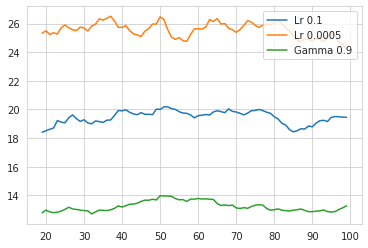

In [ ]:
tune_lr_a2c = pd.read_csv('tune_lr_a2c.csv')
tune_lr_a2c.rolling(window=20).mean().plot()

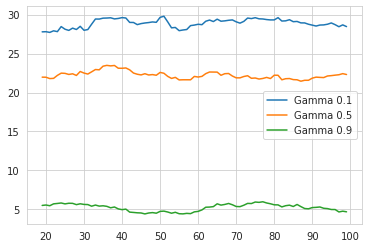

In [ ]:
tune_gamma_a2c = pd.read_csv('tune_gamma_a2c.csv')
tune_gamma_a2c.rolling(window=20).mean().plot()

In [ ]:
a2c_model.learn(total_timesteps=100000, log_interval= -1)

Streaming output truncated to the last 5000 lines.
|    n_updates          | 19666    |
|    policy_loss        | 45.1     |
|    std                | 1.11     |
|    value_loss         | 4.66     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 194      |
|    iterations         | 19668    |
|    time_elapsed       | 505      |
|    total_timesteps    | 98340    |
| train/                |          |
|    entropy_loss       | -45.6    |
|    explained_variance | 0.487    |
|    learning_rate      | 0.0005   |
|    n_updates          | 19667    |
|    policy_loss        | 26.5     |
|    std                | 1.11     |
|    value_loss         | 1.24     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 194      |
|    iterations         | 19669    |
|    time_elapsed       | 505      |
|    total_timesteps    

In [ ]:
render_trading(a2c_model, trade_env, trading_data, n_episodes = 1)

Initial Portfolio Value : 10000 | Final Portfolio Value : 36996.802972344136 | Total rewards : 26996.802972344136 | % of profit : 269.96802972344136


[array([269.96786], dtype=float32), 0.0]

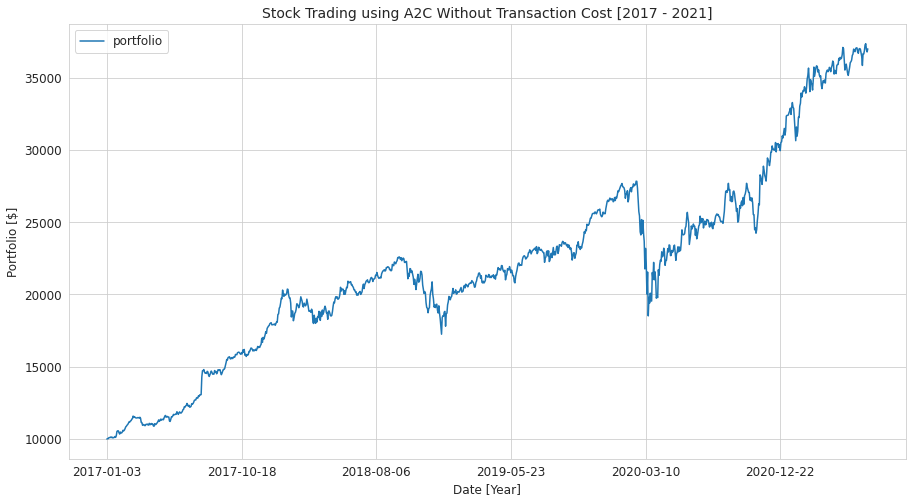

In [ ]:
a2c_result_df =  pd.read_csv('trade_results_a2c_woTC_final.csv')
a2c_result_df = a2c_result_df.drop('Unnamed: 0', axis=1).set_index('date')

a2c_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date [Year]', fontsize = 12)
plt.ylabel('Portfolio [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using A2C Without Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

With TC

In [ ]:
a2c_model.learn(total_timesteps=100000, log_interval= 10000)

------------------------------------
| time/                 |          |
|    fps                | 265      |
|    iterations         | 10000    |
|    time_elapsed       | 188      |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | 0.257    |
|    learning_rate      | 0.0005   |
|    n_updates          | 9999     |
|    policy_loss        | 116      |
|    std                | 1.04     |
|    value_loss         | 54.5     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 264      |
|    iterations         | 20000    |
|    time_elapsed       | 377      |
|    total_timesteps    | 100000   |
| train/                |          |
|    entropy_loss       | -44.6    |
|    explained_variance | 0.737    |
|    learning_rate      | 0.0005   |
|    n_updates          | 19999    |
|    policy_loss        | 115      |
|

In [ ]:
render_trading(a2c_model, trade_env, trading_data, n_episodes = 1)

Initial Portfolio Value : 10000 | Final Portfolio Value : 31858.182787422662 | Total rewards : 21858.182787422662 | % of profit : 218.58182787422663


[array([218.5819], dtype=float32), 0.0]

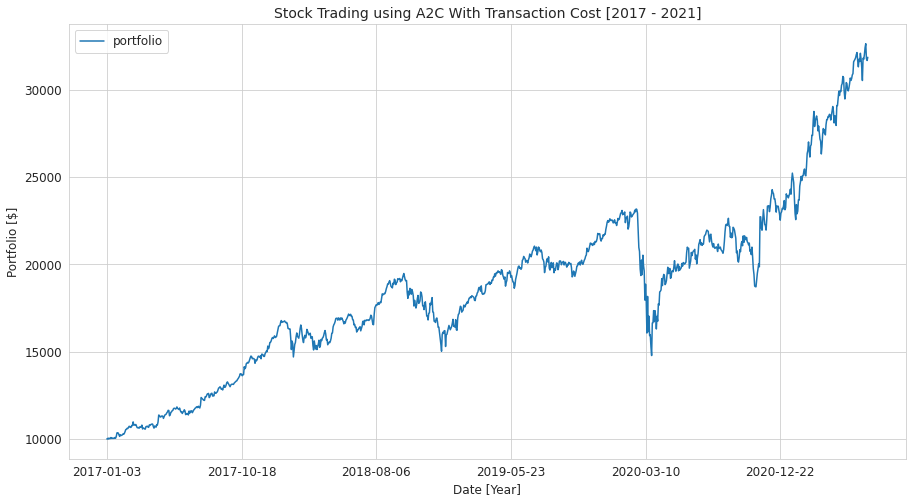

In [ ]:
a2c_result_df =  pd.read_csv('trade_results_a2c_WTC_final.csv')
a2c_result_df = a2c_result_df.drop('Unnamed: 0', axis=1).set_index('date')

a2c_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date [Year]', fontsize = 12)
plt.ylabel('Portfolio [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using A2C With Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

**PPO Model**

In [ ]:
# evaluate_policy(a2c_model, train_env, n_eval_episodes=10, return_episode_rewards=True)

In [ ]:
ppo_model = PPO('MlpPolicy', train_env, learning_rate=0.00025, n_steps=2048, ent_coef=0.01, gamma=0.1 ,verbose= 1, seed=10, batch_size=128)

Using cpu device


In [ ]:
ppo_model.learn(total_timesteps=30000, eval_env=val_env, log_interval= 10000, eval_log_path='/Validation', n_eval_episodes= 10, eval_freq=10000)

Eval num_timesteps=10000, episode_reward=18.81 +/- 0.31
Episode length: 252.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 252       |
|    mean_reward          | 18.8      |
| time/                   |           |
|    total timesteps      | 10000     |
| train/                  |           |
|    approx_kl            | 2.8473282 |
|    clip_fraction        | 0.941     |
|    clip_range           | 0.2       |
|    entropy_loss         | -61.6     |
|    explained_variance   | 0.672     |
|    learning_rate        | 0.01      |
|    loss                 | -0.143    |
|    n_updates            | 40        |
|    policy_gradient_loss | 0.128     |
|    std                  | 1.95      |
|    value_loss           | 1.29      |
---------------------------------------
New best mean reward!
Eval num_timesteps=20000, episode_reward=32.14 +/- 0.40
Episode length: 252.00 +/- 0.00
---------------------------------------
| 

In [ ]:
#Validation
val_return = render_trading(ppo_model, val_env, validation_data, n_episodes = 100)

Average reward 12.144124984741211
Average reward 10.42491626739502
Average reward 10.014938354492188
Average reward 9.640454292297363
Average reward 9.403495788574219
Average reward 9.304393768310547
Average reward 9.39441204071045
Average reward 9.66427993774414
Average reward 9.752074241638184
Average reward 10.000951766967773


In [ ]:
# tune_lr_ppo = pd.DataFrame(np.concatenate(val_return[:-1]))
# tune_lr_ppo.columns = ['Lr 0.00025']
# tune_lr_ppo['Lr 0.01'] = np.concatenate(val_return[:-1])
tune_lr_ppo.to_csv('tune_lr_ppo.csv')

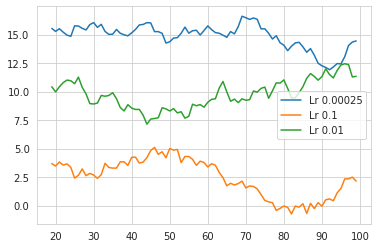

In [ ]:
# tune_gamma_ppo = pd.read_csv('tune_gamma_ppo.csv').drop('Unnamed: 0', axis=1)
tune_lr_ppo.rolling(window=20).mean().plot()

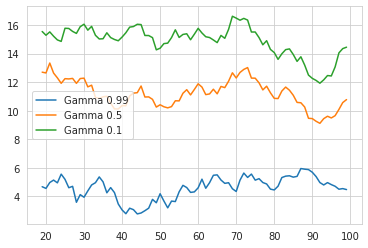

In [ ]:
tune_gamma_ppo = pd.read_csv('tune_gamma_ppo.csv').drop('Unnamed: 0', axis=1)
tune_gamma_ppo.rolling(window=20).mean().plot()

With TC

In [ ]:
ppo_model.learn(total_timesteps=100000, log_interval= 10000)

In [ ]:
render_trading(ppo_model, trade_env, trading_data, n_episodes = 1)

Initial Portfolio Value : 10000 | Final Portfolio Value : 30421.428095132953 | Total rewards : 20421.428095132953 | % of profit : 204.21428095132953


[array([204.2142], dtype=float32), 0.0]

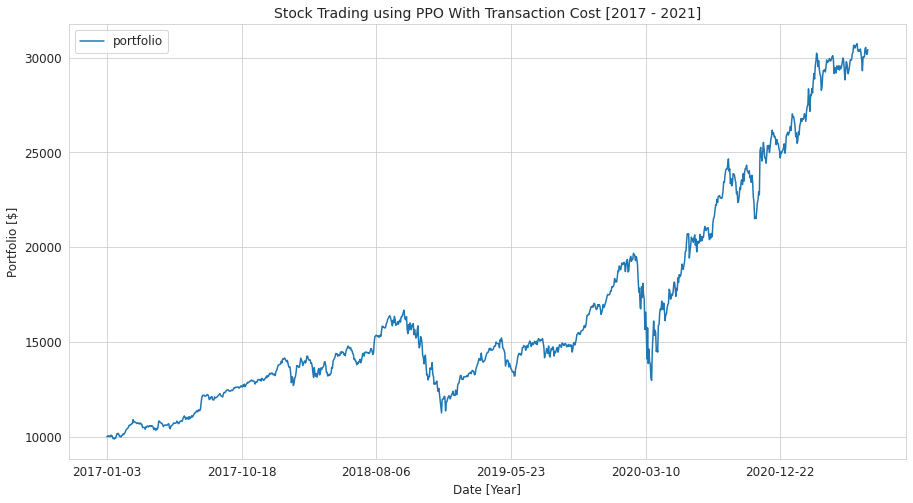

In [ ]:
ppo_result_df =  pd.read_csv('trade_results_ppo_WTC_final.csv').drop('Unnamed: 0', axis=1).set_index('date')

ppo_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date [Year]', fontsize = 12)
plt.ylabel('Portfolio [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using PPO With Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

Without TC

In [ ]:
ppo_model.learn(total_timesteps=100000)

-----------------------------
| time/              |      |
|    fps             | 409  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 388         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.023865122 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0945     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.01        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0696     |
|    std                  | 1           |
|    value_loss           | 3.83        |
----------------------------------

In [ ]:
render_trading(ppo_model, trade_env, trading_data, n_episodes = 1)

Initial Portfolio Value : 10000 | Final Portfolio Value : 35170.77035490549 | Total rewards : 25170.770354905493 | % of profit : 251.7077035490549


[array([251.7078], dtype=float32), 0.0]

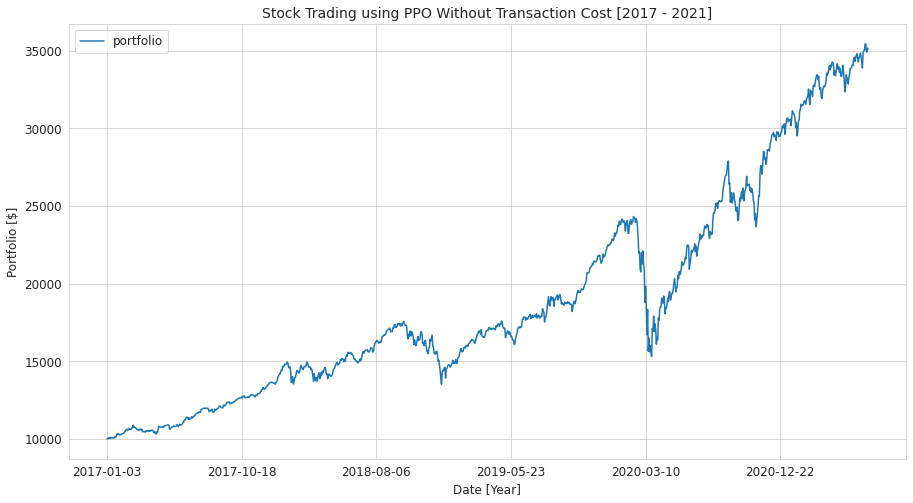

In [ ]:
ppo_result_df =  pd.read_csv('trade_results_ppo_WoTC_final.csv').drop('Unnamed: 0', axis=1).set_index('date')

ppo_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date [Year]', fontsize = 12)
plt.ylabel('Portfolio [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using PPO Without Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

In [ ]:
len(pd.read_csv('trade_results_ppo_WoTC_final.csv').drop('Unnamed: 0', axis=1)['date'].unique())

1131

**DDPG MODEL**

In [ ]:
# from stable_baselines3.common.noise import ActionNoise, OrnsteinUhlenbeckActionNoise

In [ ]:
# n_action = train_env.action_space.shape[-1]
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_action), sigma=0.1 * np.ones(n_action))
# ddpg_model = DDPG(MlpPolicy, train_env, learning_rate=0.0005, batch_size=10, gamma=0.03 ,verbose= 1, gradient_steps=0, seed=10, action_noise= action_noise)

# ddpg_model.learn(total_timesteps=50000, eval_env=val_env, log_interval= 10000, eval_log_path='/Validation', n_eval_episodes= 30, eval_freq=10000)

Using cpu device


**DJIA BUY and HOLD**

In [ ]:
djia_data = yfinance.download('DJIA', start= '2016-12-30', end=stock_end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
djia_dly_rtn = djia_data.pct_change(1).reset_index().fillna(0)
djia_dly_rtn.columns = ['Date', 'Daily_Return']
djia_dly_rtn['Cummulative_Daily_Return'] = djia_dly_rtn['Daily_Return'].values.cumsum()

In [ ]:
initial_investment = 10000
cumm_portfolio = initial_investment
portfolio = [initial_investment]
for i in djia_dly_rtn['Daily_Return']:
  cumm_portfolio += cumm_portfolio*i
  portfolio.append(cumm_portfolio)


djia_dly_rtn['Portfolio'] = portfolio[1:]

In [ ]:
djia_dly_rtn.set_index('Date', inplace= True)

In [ ]:
djia_dly_rtn.to_csv('Djia.csv')

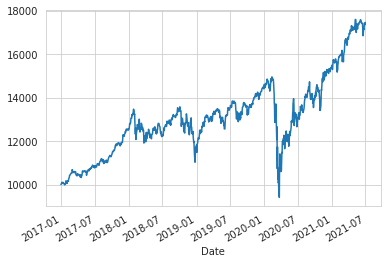

In [ ]:
djia_dly_rtn['Portfolio'].plot()

**Generating Plots and Results**

**Hyperparameter Tuning Selection**

**A2C**

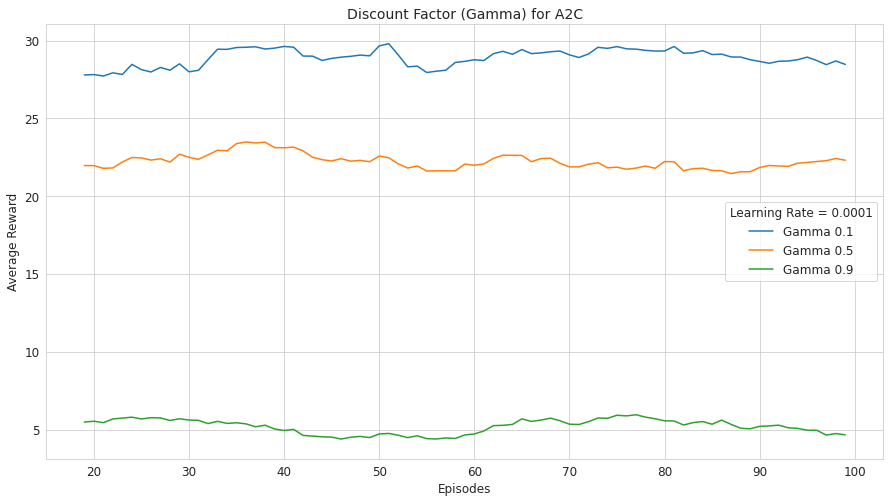

In [5]:
tune_gamma_a2c = pd.read_csv('tune_gamma_a2c.csv').drop('Unnamed: 0', axis=1)
tune_gamma_a2c.rolling(window=20).mean().plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

plt.xlabel('Episodes', fontsize = 12)
plt.ylabel('Average Reward', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Learning Rate = 0.0001', title_fontsize  ='12')
plt.title('Discount Factor (Gamma) for A2C', fontsize = 14)
plt.show()

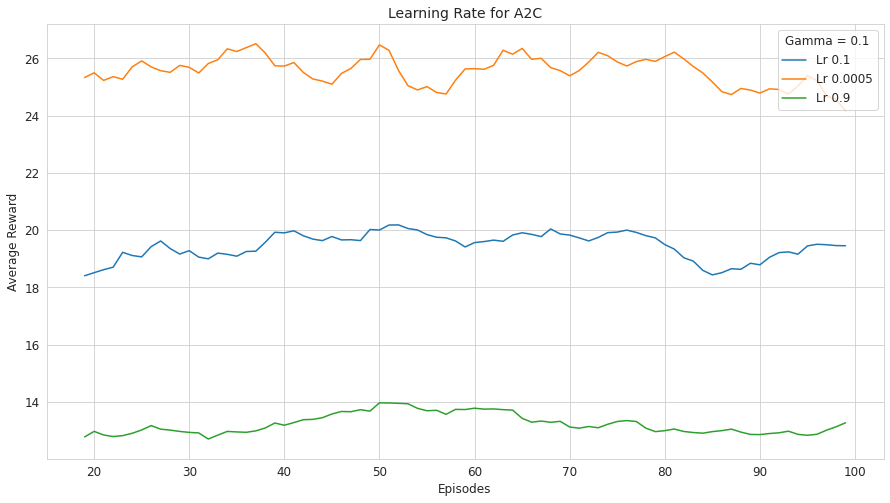

In [6]:
tune_lr_a2c = pd.read_csv('tune_lr_a2c.csv').drop('Unnamed: 0', axis=1)
tune_lr_a2c.rolling(window=20).mean().plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

plt.xlabel('Episodes', fontsize = 12)
plt.ylabel('Average Reward', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Gamma = 0.1', title_fontsize  ='12')
plt.title('Learning Rate for A2C', fontsize = 14)
plt.show()

**PPO**

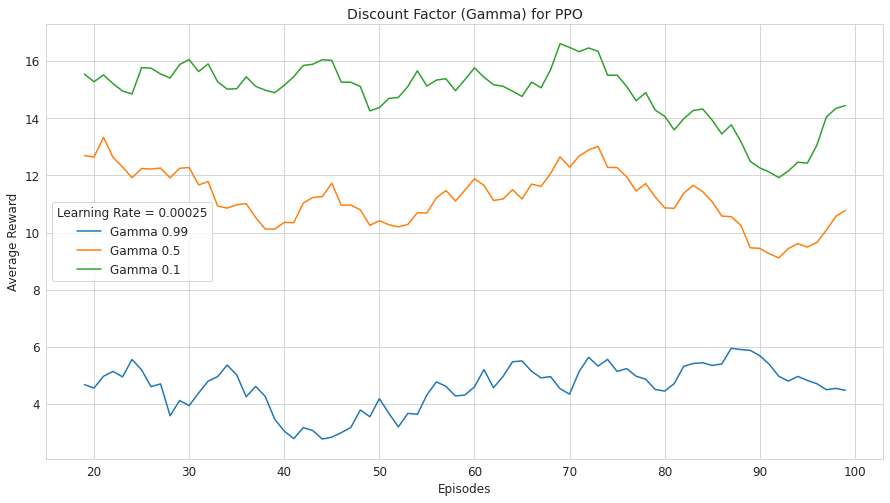

In [7]:
tune_gamma_ppo = pd.read_csv('tune_gamma_ppo.csv').drop('Unnamed: 0', axis=1)
tune_gamma_ppo.rolling(window=20).mean().plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

plt.xlabel('Episodes', fontsize = 12)
plt.ylabel('Average Reward', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Learning Rate = 0.00025', title_fontsize  ='12')
plt.title('Discount Factor (Gamma) for PPO', fontsize = 14)
plt.show()

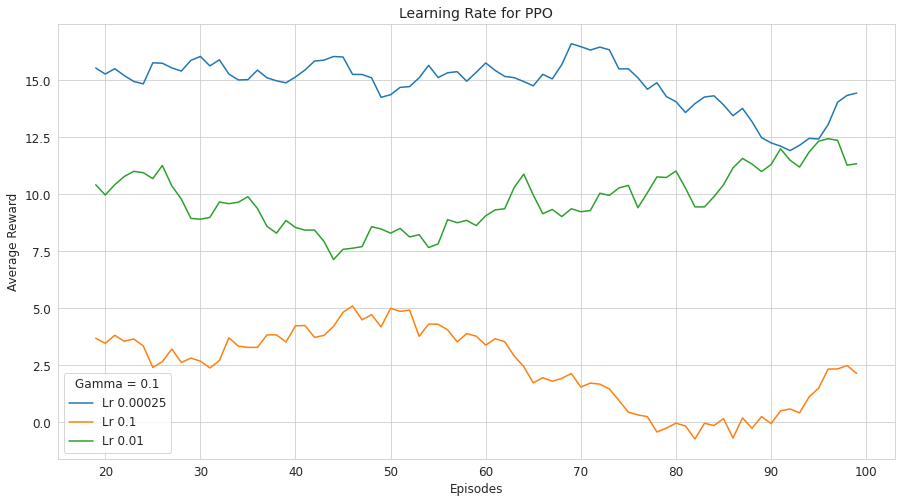

In [8]:
tune_lr_ppo = pd.read_csv('tune_lr_ppo.csv').drop('Unnamed: 0', axis=1)
tune_lr_ppo.rolling(window=20).mean().plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

plt.xlabel('Episodes', fontsize = 12)
plt.ylabel('Average Reward', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Gamma = 0.1', title_fontsize  ='12')
plt.title('Learning Rate for PPO', fontsize = 14)
plt.show()

**A2C Model Results**

Without Transaction Costs

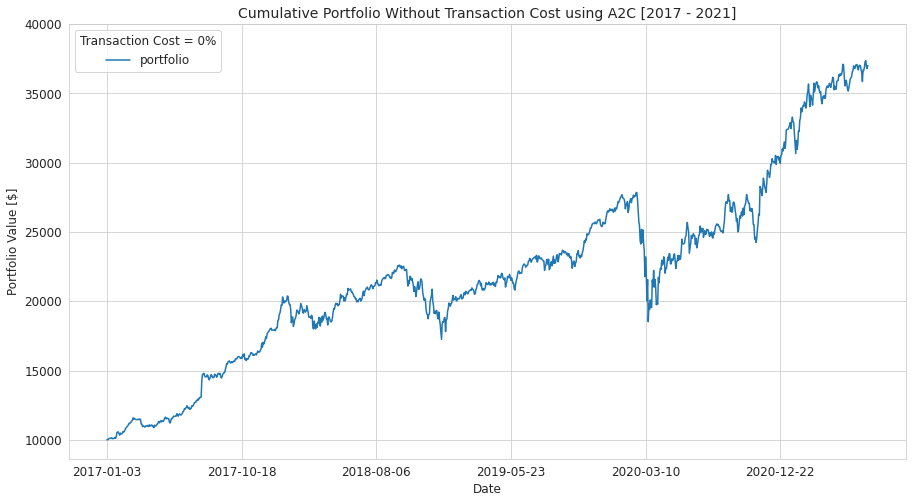

In [7]:
a2c_wotc =  pd.read_csv('trade_results_a2c_woTC_final.csv')
a2c_wotc = a2c_wotc.drop('Unnamed: 0', axis=1).set_index('date')

a2c_wotc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12, label = 'Portfolio')
plt.xlabel('Date', fontsize = 12)
plt.ylim(top = 40000)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0%', title_fontsize  ='12' )
plt.title('Cumulative Portfolio Without Transaction Cost using A2C [2017 - 2021]', fontsize = 14)
plt.show()

With Transaction Cost

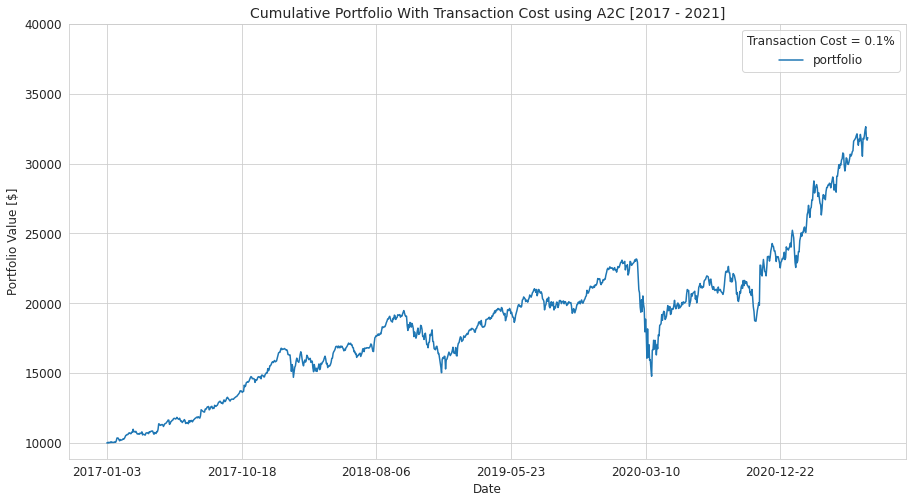

In [8]:
a2c_wtc =  pd.read_csv('trade_results_a2c_WTC_final.csv')
a2c_wtc = a2c_wtc.drop('Unnamed: 0', axis=1).set_index('date')

a2c_wtc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylim(top = 40000)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0.1%', title_fontsize  ='12' )
plt.title('Cumulative Portfolio With Transaction Cost using A2C [2017 - 2021]', fontsize = 14)
plt.show()

In [5]:
df_a2c = a2c_wotc.copy()
df_a2c.columns = ['0%']
df_a2c['0.1%'] = a2c_wtc['portfolio']

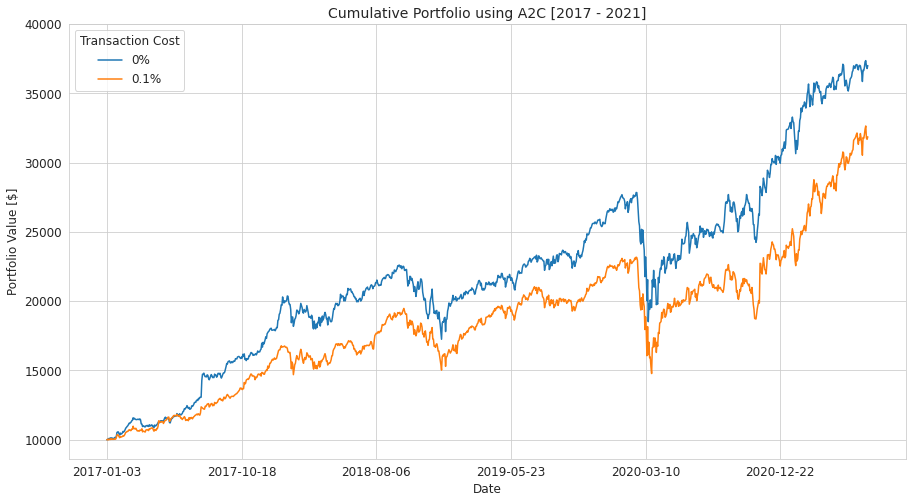

In [6]:
df_a2c.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

plt.xlabel('Date', fontsize = 12)
plt.ylim(top = 40000)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost', title_fontsize  ='12' )
plt.title('Cumulative Portfolio using A2C [2017 - 2021]', fontsize = 14)
plt.show()

**PPO Model Results**

Without Transaction Cost

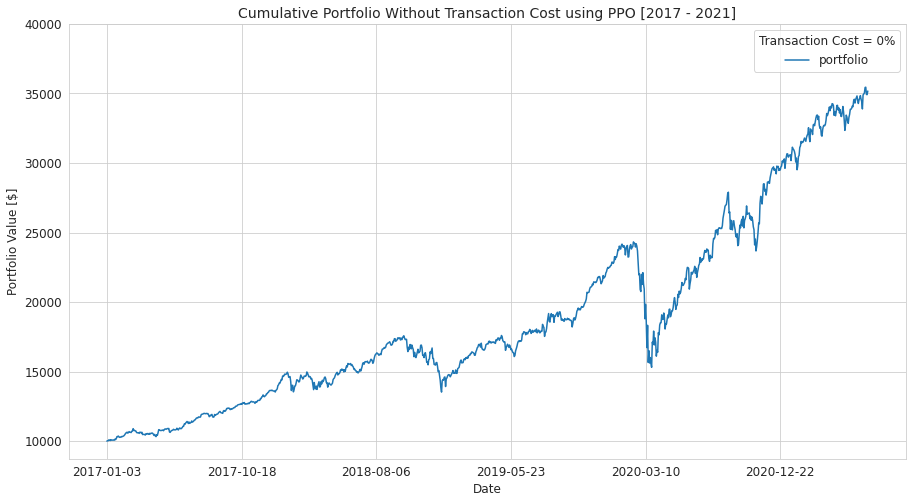

In [9]:
ppo_wotc =  pd.read_csv('trade_results_ppo_WoTC_final.csv')
ppo_wotc = ppo_wotc.drop('Unnamed: 0', axis=1).set_index('date')

ppo_wotc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylim(top = 40000)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0%', title_fontsize  ='12' )
plt.title('Cumulative Portfolio Without Transaction Cost using PPO [2017 - 2021]', fontsize = 14)
plt.show()

With Transaction Cost

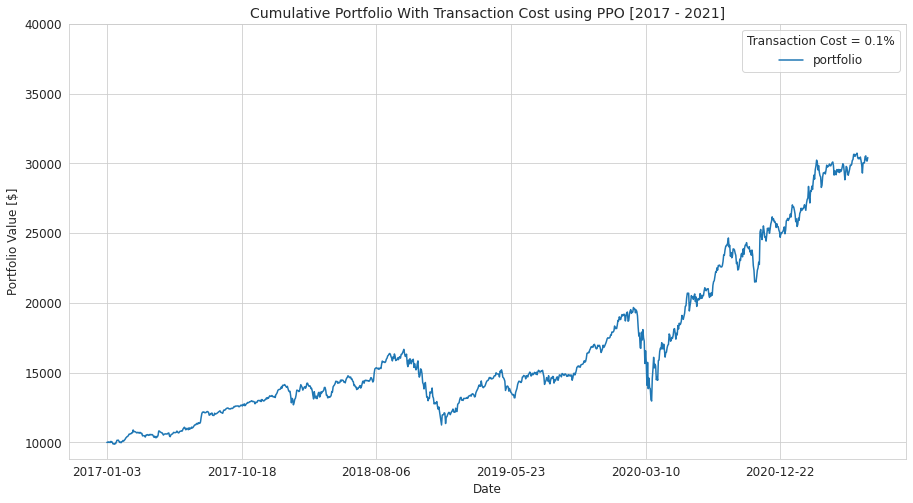

In [10]:
ppo_wtc =  pd.read_csv('trade_results_ppo_WTC_final.csv')
ppo_wtc = ppo_wtc.drop('Unnamed: 0', axis=1).set_index('date')

ppo_wtc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylim(top = 40000)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0.1%', title_fontsize  ='12' )
plt.title('Cumulative Portfolio With Transaction Cost using PPO [2017 - 2021]', fontsize = 14)
plt.show()

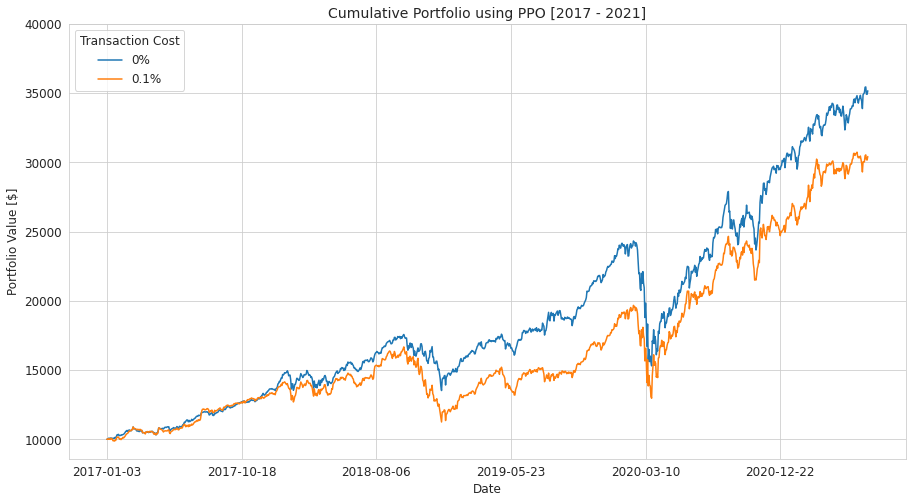

In [58]:
df_ppo = ppo_wotc.copy()
df_ppo.columns = ['0%']
df_ppo['0.1%'] = ppo_wtc['portfolio']
df_ppo.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

plt.xlabel('Date', fontsize = 12)
plt.ylim(top = 40000)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost', title_fontsize  ='12' )
plt.title('Cumulative Portfolio using PPO [2017 - 2021]', fontsize = 14)
plt.show()

**DJIA Buy and Hold**

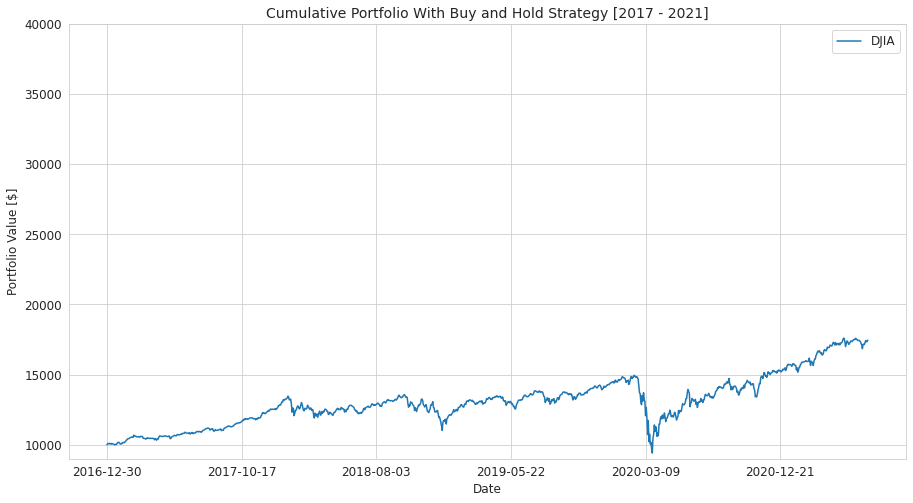

In [11]:
djia_bh =  pd.read_csv('Djia.csv')
djia_bh = djia_bh.set_index('Date')

djia_bh['Portfolio'].rename('DJIA').plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.ylim(top = 40000)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Cumulative Portfolio With Buy and Hold Strategy [2017 - 2021]', fontsize = 14)
plt.show()

**Combining Results**

Without Transaction Cost

In [12]:
df_results_wotc = a2c_wotc
df_results_wotc.columns = ['A2C']
df_results_wotc['PPO'] = ppo_wotc['portfolio'].values
df_results_wotc['DJIA'] = djia_bh['Portfolio'].values

In [ ]:
#Annualized Returns
((df_results_wotc['A2C'].pct_change(1).mean()+1)**252-1)*100

38.07401995705324

In [ ]:
#Sharpe Ratio
(4 ** 0.5) * df_results_wotc['A2C'].pct_change(1).mean() / df_results_wotc['A2C'].pct_change(1).std()

0.163827190300829

In [ ]:
#Annualized Returns
((df_results_wotc['PPO'].pct_change(1).mean()+1)**252-1)*100

36.409944797154694

In [ ]:
#Sharpe Ratio
(4 ** 0.5) * df_results_wotc['PPO'].pct_change(1).mean() / df_results_wotc['PPO'].pct_change(1).std()

0.1603507905245339

In [ ]:
#Annualized Returns
((df_results_wotc['DJIA'].pct_change(1).mean()+1)**252-1)*100

15.72913979937287

In [ ]:
#Sharpe Ratio
(4 ** 0.5) * df_results_wotc['DJIA'].pct_change(1).mean() / df_results_wotc['DJIA'].pct_change(1).std()

0.08841933127105815

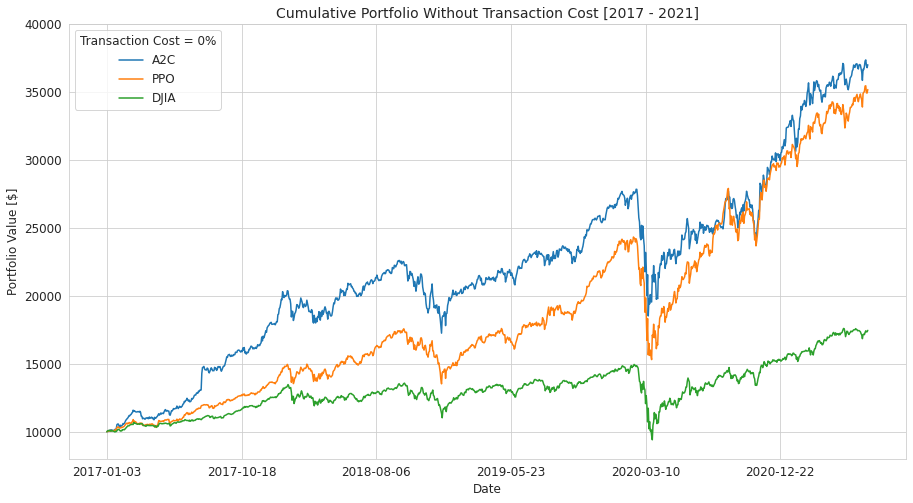

In [56]:
df_results_wotc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.ylim(top = 40000)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0%', title_fontsize  ='12')
plt.title('Cumulative Portfolio Without Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

With Transaction Cost

In [14]:
df_results_wtc = a2c_wtc
df_results_wtc.columns = ['A2C']
df_results_wtc['PPO'] = ppo_wtc['portfolio'].values
df_results_wtc['DJIA'] = djia_bh['Portfolio'].values

In [ ]:
#Annualized Returns
((df_results_wtc['A2C'].pct_change(1).mean()+1)**252-1)*100

33.861852613623356

In [ ]:
#Sharpe Ratio
(4 ** 0.5) * df_results_wtc['A2C'].pct_change(1).mean() / df_results_wtc['A2C'].pct_change(1).std()

0.1420258639088655

In [ ]:
#Annualized Returns
((df_results_wtc['PPO'].pct_change(1).mean()+1)**252-1)*100

32.444761537464714

In [ ]:
#Sharpe Ratio
(4 ** 0.5) * df_results_wtc['PPO'].pct_change(1).mean() / df_results_wtc['PPO'].pct_change(1).std()

0.13798090016349857

In [ ]:
#Annualized Returns
((df_results_wtc['DJIA'].pct_change(1).mean()+1)**252-1)*100

15.72913979937287

In [ ]:
#Sharpe Ratio
(4 ** 0.5) * df_results_wtc['DJIA'].pct_change(1).mean() / df_results_wtc['DJIA'].pct_change(1).std()

0.08841933127105815

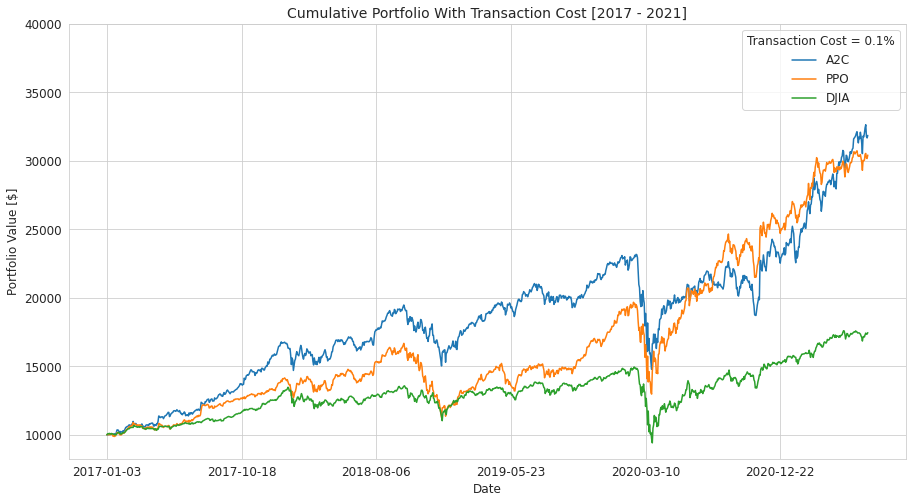

In [15]:
df_results_wtc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.ylim(top = 40000)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0.1%', title_fontsize  ='12')
plt.title('Cumulative Portfolio With Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()